In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import datetime as dt
import time

import pandas as pd
import pandas_ta as ta
import yfinance as yf

from collections import deque

In [36]:
tf.__version__

'2.10.1'

In [37]:
# check that the GPU is being used to accelerate training
len(tf.config.list_physical_devices('GPU')) > 0

True

In [38]:
STOCKS = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [39]:
STOCKS

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [7]:
# create a list of unique stock tickers from the data in STOCKS
ST_list = STOCKS['Symbol'].unique().tolist()

cur_date = (dt.date.today() - dt.timedelta(days=8)).strftime('%Y-%m-%d')
init_date = (dt.date.today() - dt.timedelta(days=(365*5)+8)).strftime('%Y-%m-%d')

init_date, cur_date

('2019-01-11', '2024-01-10')

In [8]:
# get data on all tickers
df = yf.download(tickers = ST_list,
                start = init_date,
                end = cur_date).stack()

# label the index columsn
df.index.names = ['date', 'ticker']
df

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-11 -> 2024-01-10)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


Adj Close       Close        High         Low        Open  \
date       ticker                                                               
2019-01-11 A        67.906906   70.379997   70.410004   68.940002   69.290001   
           AAL      31.293978   31.799999   31.990000   31.100000   31.799999   
           AAPL     36.542397   38.072498   38.424999   37.877499   38.220001   
           ABBV     69.256439   88.309998   88.309998   87.540001   87.540001   
           ABT      63.445335   69.330002   69.360001   68.449997   68.599998   
...                       ...         ...         ...         ...         ...   
2024-01-09 YUM     128.220001  128.220001  128.300003  127.260002  127.860001   
           ZBH     121.870003  121.870003  124.269997  120.660004  121.629997   
           ZBRA    256.440002  256.440002  259.660004  255.000000  255.820007   
           ZION     44.040001   44.040001   44.590000   43.380001   43.840000   
           ZTS     195.940002  195.940002  199.830002  194.050003  195.550003   

                        Volume  
date       ticker               
2019-01-11 A         1210800.0  
           AAL       6900100.0  
           AAPL    108092800.0  
           ABBV      5318100.0  
           ABT       6583000.0  
...                        ...  
2024-01-09 YUM        968400.0  
           ZBH       2921800.0  
           ZBRA       326600.0  
           ZION      1388200.0  
           ZTS       1983200.0  

[624351 rows x 6 columns]

In [40]:
# BRK.B and BF.B have a '.' but they need a '-' to be correctly called from yfinance
STOCKS['Symbol'] = STOCKS['Symbol'].str.replace('.', '-')
ST_list = STOCKS['Symbol'].unique().tolist()

In [41]:
# get data on all tickers
df = yf.download(tickers = ST_list,
                start = init_date,
                end = cur_date).stack()

# label the index columsn
df.index.names = ['date', 'ticker']
df

[*********************100%%**********************]  503 of 503 completed


Adj Close       Close        High         Low        Open  \
date       ticker                                                               
2019-01-11 A        67.906891   70.379997   70.410004   68.940002   69.290001   
           AAL      31.293976   31.799999   31.990000   31.100000   31.799999   
           AAPL     36.542393   38.072498   38.424999   37.877499   38.220001   
           ABBV     69.256447   88.309998   88.309998   87.540001   87.540001   
           ABT      63.445354   69.330002   69.360001   68.449997   68.599998   
...                       ...         ...         ...         ...         ...   
2024-01-09 YUM     128.220001  128.220001  128.300003  127.260002  127.860001   
           ZBH     121.870003  121.870003  124.269997  120.660004  121.629997   
           ZBRA    256.440002  256.440002  259.660004  255.000000  255.820007   
           ZION     44.040001   44.040001   44.590000   43.380001   43.840000   
           ZTS     195.496597  195.940002  199.830002  194.050003  195.550003   

                        Volume  
date       ticker               
2019-01-11 A         1210800.0  
           AAL       6900100.0  
           AAPL    108092800.0  
           ABBV      5318100.0  
           ABT       6583000.0  
...                        ...  
2024-01-09 YUM        968400.0  
           ZBH       2921800.0  
           ZBRA       326600.0  
           ZION      1388200.0  
           ZTS       1983200.0  

[626865 rows x 6 columns]

In [42]:
# calculate RSI
df['Rsi'] = df.groupby(level=1)['Adj Close'].transform(ta.rsi, length=15)

#calculate MACD
def compute_macd(closing_prices):
    macd_values = ta.macd(close=closing_prices, length=15).iloc[:,0]
    return(macd_values - macd_values.mean())/macd_values.std()
df['Macd'] = df.groupby(level=1, group_keys=False)['Adj Close'].transform(compute_macd)

# Calculate ATR
def compute_atr(price_data):
    avg_true_range = ta.atr(
        high = price_data['High'],
        low = price_data['Low'],
        close = price_data['Close'],
        length = 14)
    return (avg_true_range - avg_true_range.mean()) / avg_true_range.std()
df['Atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [43]:
df

Adj Close       Close        High         Low        Open  \
date       ticker                                                               
2019-01-11 A        67.906891   70.379997   70.410004   68.940002   69.290001   
           AAL      31.293976   31.799999   31.990000   31.100000   31.799999   
           AAPL     36.542393   38.072498   38.424999   37.877499   38.220001   
           ABBV     69.256447   88.309998   88.309998   87.540001   87.540001   
           ABT      63.445354   69.330002   69.360001   68.449997   68.599998   
...                       ...         ...         ...         ...         ...   
2024-01-09 YUM     128.220001  128.220001  128.300003  127.260002  127.860001   
           ZBH     121.870003  121.870003  124.269997  120.660004  121.629997   
           ZBRA    256.440002  256.440002  259.660004  255.000000  255.820007   
           ZION     44.040001   44.040001   44.590000   43.380001   43.840000   
           ZTS     195.496597  195.940002  199.830002  194.050003  195.550003   

                        Volume        Rsi      Macd       Atr  
date       ticker                                              
2019-01-11 A         1210800.0        NaN       NaN       NaN  
           AAL       6900100.0        NaN       NaN       NaN  
           AAPL    108092800.0        NaN       NaN       NaN  
           ABBV      5318100.0        NaN       NaN       NaN  
           ABT       6583000.0        NaN       NaN       NaN  
...                        ...        ...       ...       ...  
2024-01-09 YUM        968400.0  49.700200  0.181875 -0.649722  
           ZBH       2921800.0  68.057421  0.651897 -1.167871  
           ZBRA       326600.0  52.530807  0.534541 -0.806302  
           ZION      1388200.0  59.810270  1.275825 -0.164497  
           ZTS       1983200.0  62.085004  1.042856 -0.120530  

[626865 rows x 9 columns]

In [44]:
# make a copy of df to freely manipulate
df_copy = df.copy()

# pick the stock to analyse
STOCK = 'PG'
df_individual = df_copy.loc[(df_copy.index.get_level_values('ticker') == STOCK)]
df_individual

,,Adj Close,Close,High,Low,Open,Volume,Rsi,Macd,Atr
date,ticker,,,,,,,,,
2019-01-11,PG,80.352509,91.769997,91.980003,91.110001,91.669998,7166600.0,NaN,NaN,NaN
2019-01-14,PG,79.809669,91.150002,91.910004,90.849998,91.500000,7952000.0,NaN,NaN,NaN
2019-01-15,PG,80.562660,92.010002,92.610001,91.139999,91.150002,7834500.0,NaN,NaN,NaN
2019-01-16,PG,80.002289,91.370003,92.150002,90.989998,91.739998,7964500.0,NaN,NaN,NaN
2019-01-17,PG,79.990822,90.639999,91.559998,90.349998,90.709999,8044500.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-01-03,PG,146.912170,147.839996,149.199997,147.179993,148.339996,7697500.0,51.634256,-0.593247,-0.413326
2024-01-04,PG,147.717087,148.649994,149.270004,147.770004,148.050003,7067400.0,53.993175,-0.463807,-0.447110
2024-01-05,PG,146.494812,147.419998,148.869995,146.550003,148.720001,5294200.0,50.023706,-0.423339,-0.410806


In [45]:
# remove index labels to later remove ticker
df_individual = df_individual.reset_index()

# remove ticker column
df_individual = df_individual.drop('ticker', axis=1)
df_individual

,date,Adj Close,Close,High,Low,Open,Volume,Rsi,Macd,Atr
0,2019-01-11,80.352509,91.769997,91.980003,91.110001,91.669998,7166600.0,NaN,NaN,NaN
1,2019-01-14,79.809669,91.150002,91.910004,90.849998,91.500000,7952000.0,NaN,NaN,NaN
2,2019-01-15,80.562660,92.010002,92.610001,91.139999,91.150002,7834500.0,NaN,NaN,NaN
3,2019-01-16,80.002289,91.370003,92.150002,90.989998,91.739998,7964500.0,NaN,NaN,NaN
4,2019-01-17,79.990822,90.639999,91.559998,90.349998,90.709999,8044500.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1252,2024-01-03,146.912170,147.839996,149.199997,147.179993,148.339996,7697500.0,51.634256,-0.593247,-0.413326
1253,2024-01-04,147.717087,148.649994,149.270004,147.770004,148.050003,7067400.0,53.993175,-0.463807,-0.447110
1254,2024-01-05,146.494812,147.419998,148.869995,146.550003,148.720001,5294200.0,50.023706,-0.423339,-0.410806
1255,2024-01-08,147.756851,148.690002,148.919998,147.649994,147.910004,8255300.0,53.782650,-0.323971,-0.444771


In [46]:
# calculate an intra day average from price highs and lows
df_individual['Average'] = (df_individual['High'] + df_individual['Low'])/2
df_individual

,date,Adj Close,Close,High,Low,Open,Volume,Rsi,Macd,Atr,Average
0,2019-01-11,80.352509,91.769997,91.980003,91.110001,91.669998,7166600.0,NaN,NaN,NaN,91.545002
1,2019-01-14,79.809669,91.150002,91.910004,90.849998,91.500000,7952000.0,NaN,NaN,NaN,91.380001
2,2019-01-15,80.562660,92.010002,92.610001,91.139999,91.150002,7834500.0,NaN,NaN,NaN,91.875000
3,2019-01-16,80.002289,91.370003,92.150002,90.989998,91.739998,7964500.0,NaN,NaN,NaN,91.570000
4,2019-01-17,79.990822,90.639999,91.559998,90.349998,90.709999,8044500.0,NaN,NaN,NaN,90.954998
...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-01-03,146.912170,147.839996,149.199997,147.179993,148.339996,7697500.0,51.634256,-0.593247,-0.413326,148.189995
1253,2024-01-04,147.717087,148.649994,149.270004,147.770004,148.050003,7067400.0,53.993175,-0.463807,-0.447110,148.520004
1254,2024-01-05,146.494812,147.419998,148.869995,146.550003,148.720001,5294200.0,50.023706,-0.423339,-0.410806,147.709999
1255,2024-01-08,147.756851,148.690002,148.919998,147.649994,147.910004,8255300.0,53.782650,-0.323971,-0.444771,148.284996


In [47]:
# set date as an index again
df_individual = df_individual.set_index(['date'])
df_individual

,Adj Close,Close,High,Low,Open,Volume,Rsi,Macd,Atr,Average
date,,,,,,,,,,
2019-01-11,80.352509,91.769997,91.980003,91.110001,91.669998,7166600.0,NaN,NaN,NaN,91.545002
2019-01-14,79.809669,91.150002,91.910004,90.849998,91.500000,7952000.0,NaN,NaN,NaN,91.380001
2019-01-15,80.562660,92.010002,92.610001,91.139999,91.150002,7834500.0,NaN,NaN,NaN,91.875000
2019-01-16,80.002289,91.370003,92.150002,90.989998,91.739998,7964500.0,NaN,NaN,NaN,91.570000
2019-01-17,79.990822,90.639999,91.559998,90.349998,90.709999,8044500.0,NaN,NaN,NaN,90.954998
...,...,...,...,...,...,...,...,...,...,...
2024-01-03,146.912170,147.839996,149.199997,147.179993,148.339996,7697500.0,51.634256,-0.593247,-0.413326,148.189995
2024-01-04,147.717087,148.649994,149.270004,147.770004,148.050003,7067400.0,53.993175,-0.463807,-0.447110,148.520004
2024-01-05,146.494812,147.419998,148.869995,146.550003,148.720001,5294200.0,50.023706,-0.423339,-0.410806,147.709999


In [48]:
# check entries
total_rows = len(df_individual)
total_rows

1257

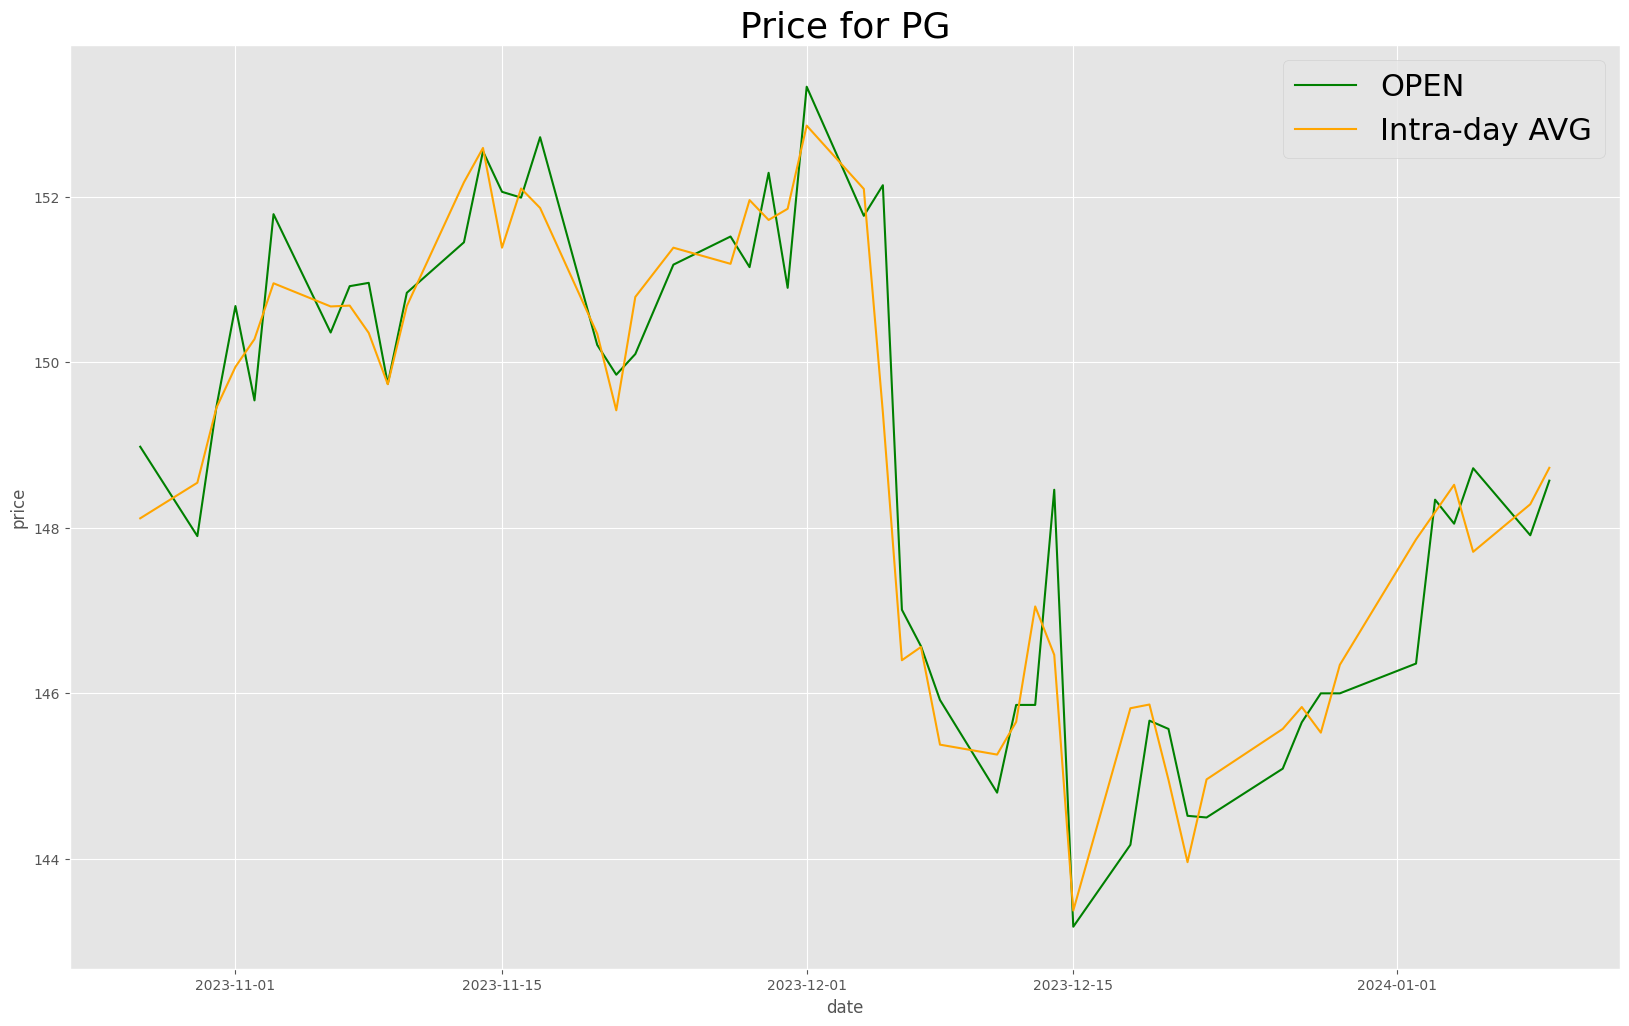

In [49]:
# Plot the price on open to compare against the intra-day average

DAYS = 50

plt.style.use(style='ggplot')
plt.figure(figsize=(20,12))
plt.title(f'Price for {STOCK}', fontsize=26)
plt.plot(df_individual['Open'][-DAYS:], color='g', label='OPEN')
plt.plot(df_individual['Average'][-DAYS:], color='orange', label='Intra-day AVG')
plt.xlabel('date')
plt.ylabel('price')
plt.legend(fontsize=22)
plt.show()

TIME SERIES ANALYSIS ON PRICE ALONE

In [50]:
# pick Scaler (MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler)
scaler = MinMaxScaler()
# change the transformed column from CLose to Average to check on the middle ground between daily lows and highs
df_individual['Scaled'] = scaler.fit_transform(np.expand_dims(df_individual['Close'].values, axis=1))
df_individual

,Adj Close,Close,High,Low,Open,Volume,Rsi,Macd,Atr,Average,Scaled
date,,,,,,,,,,,
2019-01-11,80.352509,91.769997,91.980003,91.110001,91.669998,7166600.0,NaN,NaN,NaN,91.545002,0.018029
2019-01-14,79.809669,91.150002,91.910004,90.849998,91.500000,7952000.0,NaN,NaN,NaN,91.380001,0.009624
2019-01-15,80.562660,92.010002,92.610001,91.139999,91.150002,7834500.0,NaN,NaN,NaN,91.875000,0.021282
2019-01-16,80.002289,91.370003,92.150002,90.989998,91.739998,7964500.0,NaN,NaN,NaN,91.570000,0.012607
2019-01-17,79.990822,90.639999,91.559998,90.349998,90.709999,8044500.0,NaN,NaN,NaN,90.954998,0.002711
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03,146.912170,147.839996,149.199997,147.179993,148.339996,7697500.0,51.634256,-0.593247,-0.413326,148.189995,0.778094
2024-01-04,147.717087,148.649994,149.270004,147.770004,148.050003,7067400.0,53.993175,-0.463807,-0.447110,148.520004,0.789074
2024-01-05,146.494812,147.419998,148.869995,146.550003,148.720001,5294200.0,50.023706,-0.423339,-0.410806,147.709999,0.772401


In [51]:
df_individual['Date'] = df_individual.index
df_individual

,Adj Close,Close,High,Low,Open,Volume,Rsi,Macd,Atr,Average,Scaled,Date
date,,,,,,,,,,,,
2019-01-11,80.352509,91.769997,91.980003,91.110001,91.669998,7166600.0,NaN,NaN,NaN,91.545002,0.018029,2019-01-11
2019-01-14,79.809669,91.150002,91.910004,90.849998,91.500000,7952000.0,NaN,NaN,NaN,91.380001,0.009624,2019-01-14
2019-01-15,80.562660,92.010002,92.610001,91.139999,91.150002,7834500.0,NaN,NaN,NaN,91.875000,0.021282,2019-01-15
2019-01-16,80.002289,91.370003,92.150002,90.989998,91.739998,7964500.0,NaN,NaN,NaN,91.570000,0.012607,2019-01-16
2019-01-17,79.990822,90.639999,91.559998,90.349998,90.709999,8044500.0,NaN,NaN,NaN,90.954998,0.002711,2019-01-17
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03,146.912170,147.839996,149.199997,147.179993,148.339996,7697500.0,51.634256,-0.593247,-0.413326,148.189995,0.778094,2024-01-03
2024-01-04,147.717087,148.649994,149.270004,147.770004,148.050003,7067400.0,53.993175,-0.463807,-0.447110,148.520004,0.789074,2024-01-04
2024-01-05,146.494812,147.419998,148.869995,146.550003,148.720001,5294200.0,50.023706,-0.423339,-0.410806,147.709999,0.772401,2024-01-05


In [22]:
# Set up number of days for window size
N_days = 15
# set the sequence of days to predict for
STEPS = [1,2,3,4,5]

In [23]:
def prepare_data_for_prediction(initial_data, prediction_window_size):
    # Avoid modifying the original DataFrame
    data = initial_data.copy()

    # Efficiently create 'Future_scaled' column using vectorized operations
    data["Future_scaled"] = data["Scaled"].shift(-prediction_window_size)

    # Pre-allocate lst_seq with correct shape and dtype for efficiency
    lst_seq = np.empty((prediction_window_size + N_days, 1), dtype=np.float32)
    lst_seq[-prediction_window_size:] = data[["Scaled"]].tail(prediction_window_size).values

    # Drop null values efficiently
    data.dropna(inplace=True)

    sequences = deque(maxlen=N_days)
    input_sequences = np.zeros((len(data) - N_days, N_days, 1), dtype=np.float32)  # Pre-allocate with correct shape
    target_values = np.empty_like(data["Future_scaled"].iloc[N_days:])  # Pre-allocate with correct shape

    for i, (scaled_entries, future_value) in enumerate(zip(data[["Scaled"]].values, data["Future_scaled"].values)):
        sequences.append(scaled_entries)

        if len(sequences) == N_days:
            input_sequences[i - N_days] = np.array(sequences)
            target_values[i - N_days] = future_value

    # Fill remaining values in lst_seq efficiently
    lst_seq[:N_days] = np.array([s[0] for s in sequences])

    return data, lst_seq, input_sequences, target_values

In [24]:
temp = prepare_data_for_prediction(df_individual,1)
temp

(             Adj Close       Close        High         Low        Open  \
 date                                                                     
 2019-02-19   88.799568   99.989998  100.000000   98.470001   98.559998   
 2019-02-20   88.169037   99.279999  100.220001   98.940002   99.779999   
 2019-02-21   88.613075   99.779999   99.860001   98.589996   99.099998   
 2019-02-22   89.030472  100.250000  100.400002   99.400002   99.690002   
 2019-02-25   88.426582   99.570000  100.449997   99.330002  100.360001   
 ...                ...         ...         ...         ...         ...   
 2024-01-02  148.740005  148.740005  149.410004  146.309998  146.360001   
 2024-01-03  147.839996  147.839996  149.199997  147.179993  148.339996   
 2024-01-04  148.649994  148.649994  149.270004  147.770004  148.050003   
 2024-01-05  147.419998  147.419998  148.869995  146.550003  148.720001   
 2024-01-08  148.690002  148.690002  148.919998  147.649994  147.910004   
 
                 Volume

In [25]:
def build_and_train_time_series_model(input_sequences, target_values):
    
    model = Sequential()
    model.add(LSTM(85, return_sequences=True, input_shape=(N_days, len(['Scaled']))))
    model.add(Dropout(0.2))
    model.add(LSTM(170, return_sequences=False))
    model.add(Dropout(0.35))
    model.add(LSTM(40, return_sequences=False))
    model.add(Dropout(0.3)
    model.add(Dense(35))
    model.add(Dense(20))
    model.add(Dense(1))

    '''
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(85, return_sequences=True, input_shape=(N_days, len(['Scaled']))),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(170, return_sequences=False),
        tf.keras.layers.Dropout(0.35),
        tf.keras.layers.LSTM(0, return_sequences=False),
        tf.keras.layers.Dropout(0.35),
        # ReLU activation for dense layers
        tf.keras.layers.Dense(35, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
         # Single output for prediction
        tf.keras.layers.Dense(1)
    ])
    '''

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(input_sequences, target_values, batch_size=8, epochs=120, verbose=2)
    model.summary()

    return model

In [52]:
all_predictions = []

# Pre-allocate arrays for efficiency
input_sequences = np.empty((0, N_days, 1), dtype=np.float32)  # Shape for all prediction steps
target_values = np.empty(0, dtype=np.float32)  # Shape for all prediction steps

for prediction_horizon in STEPS:
    data, lst_seq, step_input_sequences, step_target_values = prepare_data_for_prediction(df_individual, prediction_horizon)

    # Concatenate data for all prediction steps (avoiding redundant model building)
    input_sequences = np.concatenate((input_sequences, step_input_sequences), axis=0)
    target_values = np.concatenate((target_values, step_target_values), axis=0)

# Build and train the model once for all prediction steps
model = build_and_train_time_series_model(input_sequences, target_values)

for prediction_horizon in STEPS:
    # Get relevant recent data for the current prediction step
    recent_data = lst_seq[-N_days:]
    prediction_input = np.expand_dims(recent_data, axis=0)

    predicted_value = model.predict(prediction_input)
    predicted_price = scaler.inverse_transform(predicted_value)[0][0]
    all_predictions.append(round(float(predicted_price), 2))

(1217, 15, 1)
(1217,)
Epoch 1/120
153/153 - 3s - loss: 0.0171 - 3s/epoch - 22ms/step
Epoch 2/120
153/153 - 1s - loss: 0.0042 - 934ms/epoch - 6ms/step
Epoch 3/120
153/153 - 1s - loss: 0.0037 - 927ms/epoch - 6ms/step
Epoch 4/120
153/153 - 1s - loss: 0.0028 - 921ms/epoch - 6ms/step
Epoch 5/120
153/153 - 1s - loss: 0.0024 - 924ms/epoch - 6ms/step
Epoch 6/120
153/153 - 1s - loss: 0.0021 - 929ms/epoch - 6ms/step
Epoch 7/120
153/153 - 1s - loss: 0.0020 - 914ms/epoch - 6ms/step
Epoch 8/120
153/153 - 1s - loss: 0.0020 - 936ms/epoch - 6ms/step
Epoch 9/120
153/153 - 1s - loss: 0.0018 - 1s/epoch - 7ms/step
Epoch 10/120
153/153 - 1s - loss: 0.0019 - 978ms/epoch - 6ms/step
Epoch 11/120
153/153 - 1s - loss: 0.0017 - 982ms/epoch - 6ms/step
Epoch 12/120
153/153 - 1s - loss: 0.0018 - 976ms/epoch - 6ms/step
Epoch 13/120
153/153 - 1s - loss: 0.0017 - 948ms/epoch - 6ms/step
Epoch 14/120
153/153 - 1s - loss: 0.0016 - 923ms/epoch - 6ms/step
Epoch 15/120
153/153 - 1s - loss: 0.0018 - 941ms/epoch - 6ms/step
Ep

                                                                 
 dropout_14 (Dropout)        (None, 15, 85)            0         
                                                                 
 lstm_15 (LSTM)              (None, 130)               112320    
                                                                 
 dropout_15 (Dropout)        (None, 130)               0         
                                                                 
 dense_21 (Dense)            (None, 35)                4585      
                                                                 
 dense_22 (Dense)            (None, 20)                720       
                                                                 
 dense_23 (Dense)            (None, 1)                 21        
                                                                 
Total params: 147,226
Trainable params: 147,226
Non-trainable params: 0
_________________________________________________________________
1/1 

Epoch 98/120
152/152 - 1s - loss: 0.0015 - 797ms/epoch - 5ms/step
Epoch 99/120
152/152 - 1s - loss: 0.0015 - 792ms/epoch - 5ms/step
Epoch 100/120
152/152 - 1s - loss: 0.0015 - 798ms/epoch - 5ms/step
Epoch 101/120
152/152 - 1s - loss: 0.0016 - 794ms/epoch - 5ms/step
Epoch 102/120
152/152 - 1s - loss: 0.0015 - 796ms/epoch - 5ms/step
Epoch 103/120
152/152 - 1s - loss: 0.0016 - 794ms/epoch - 5ms/step
Epoch 104/120
152/152 - 1s - loss: 0.0015 - 811ms/epoch - 5ms/step
Epoch 105/120
152/152 - 1s - loss: 0.0016 - 803ms/epoch - 5ms/step
Epoch 106/120
152/152 - 1s - loss: 0.0014 - 793ms/epoch - 5ms/step
Epoch 107/120
152/152 - 1s - loss: 0.0014 - 794ms/epoch - 5ms/step
Epoch 108/120
152/152 - 1s - loss: 0.0016 - 791ms/epoch - 5ms/step
Epoch 109/120
152/152 - 1s - loss: 0.0014 - 789ms/epoch - 5ms/step
Epoch 110/120
152/152 - 1s - loss: 0.0015 - 794ms/epoch - 5ms/step
Epoch 111/120
152/152 - 1s - loss: 0.0016 - 794ms/epoch - 5ms/step
Epoch 112/120
152/152 - 1s - loss: 0.0015 - 789ms/epoch - 5ms/st

Epoch 81/120
152/152 - 1s - loss: 0.0019 - 899ms/epoch - 6ms/step
Epoch 82/120
152/152 - 1s - loss: 0.0019 - 931ms/epoch - 6ms/step
Epoch 83/120
152/152 - 1s - loss: 0.0020 - 965ms/epoch - 6ms/step
Epoch 84/120
152/152 - 1s - loss: 0.0018 - 953ms/epoch - 6ms/step
Epoch 85/120
152/152 - 1s - loss: 0.0019 - 912ms/epoch - 6ms/step
Epoch 86/120
152/152 - 1s - loss: 0.0019 - 921ms/epoch - 6ms/step
Epoch 87/120
152/152 - 1s - loss: 0.0021 - 929ms/epoch - 6ms/step
Epoch 88/120
152/152 - 1s - loss: 0.0020 - 952ms/epoch - 6ms/step
Epoch 89/120
152/152 - 1s - loss: 0.0020 - 938ms/epoch - 6ms/step
Epoch 90/120
152/152 - 1s - loss: 0.0020 - 941ms/epoch - 6ms/step
Epoch 91/120
152/152 - 1s - loss: 0.0019 - 967ms/epoch - 6ms/step
Epoch 92/120
152/152 - 1s - loss: 0.0018 - 934ms/epoch - 6ms/step
Epoch 93/120
152/152 - 1s - loss: 0.0021 - 906ms/epoch - 6ms/step
Epoch 94/120
152/152 - 1s - loss: 0.0020 - 901ms/epoch - 6ms/step
Epoch 95/120
152/152 - 1s - loss: 0.0019 - 931ms/epoch - 6ms/step
Epoch 96/1

Epoch 64/120
152/152 - 1s - loss: 0.0025 - 920ms/epoch - 6ms/step
Epoch 65/120
152/152 - 1s - loss: 0.0024 - 920ms/epoch - 6ms/step
Epoch 66/120
152/152 - 1s - loss: 0.0024 - 908ms/epoch - 6ms/step
Epoch 67/120
152/152 - 1s - loss: 0.0026 - 914ms/epoch - 6ms/step
Epoch 68/120
152/152 - 1s - loss: 0.0026 - 930ms/epoch - 6ms/step
Epoch 69/120
152/152 - 1s - loss: 0.0024 - 904ms/epoch - 6ms/step
Epoch 70/120
152/152 - 1s - loss: 0.0024 - 910ms/epoch - 6ms/step
Epoch 71/120
152/152 - 1s - loss: 0.0022 - 914ms/epoch - 6ms/step
Epoch 72/120
152/152 - 1s - loss: 0.0024 - 912ms/epoch - 6ms/step
Epoch 73/120
152/152 - 1s - loss: 0.0024 - 922ms/epoch - 6ms/step
Epoch 74/120
152/152 - 1s - loss: 0.0025 - 917ms/epoch - 6ms/step
Epoch 75/120
152/152 - 1s - loss: 0.0023 - 918ms/epoch - 6ms/step
Epoch 76/120
152/152 - 1s - loss: 0.0023 - 917ms/epoch - 6ms/step
Epoch 77/120
152/152 - 1s - loss: 0.0023 - 925ms/epoch - 6ms/step
Epoch 78/120
152/152 - 1s - loss: 0.0022 - 915ms/epoch - 6ms/step
Epoch 79/1

Epoch 47/120
152/152 - 1s - loss: 0.0028 - 933ms/epoch - 6ms/step
Epoch 48/120
152/152 - 1s - loss: 0.0028 - 950ms/epoch - 6ms/step
Epoch 49/120
152/152 - 1s - loss: 0.0030 - 919ms/epoch - 6ms/step
Epoch 50/120
152/152 - 1s - loss: 0.0028 - 925ms/epoch - 6ms/step
Epoch 51/120
152/152 - 1s - loss: 0.0028 - 919ms/epoch - 6ms/step
Epoch 52/120
152/152 - 1s - loss: 0.0027 - 917ms/epoch - 6ms/step
Epoch 53/120
152/152 - 1s - loss: 0.0027 - 937ms/epoch - 6ms/step
Epoch 54/120
152/152 - 1s - loss: 0.0028 - 937ms/epoch - 6ms/step
Epoch 55/120
152/152 - 1s - loss: 0.0027 - 929ms/epoch - 6ms/step
Epoch 56/120
152/152 - 1s - loss: 0.0028 - 931ms/epoch - 6ms/step
Epoch 57/120
152/152 - 1s - loss: 0.0026 - 929ms/epoch - 6ms/step
Epoch 58/120
152/152 - 1s - loss: 0.0028 - 919ms/epoch - 6ms/step
Epoch 59/120
152/152 - 1s - loss: 0.0029 - 926ms/epoch - 6ms/step
Epoch 60/120
152/152 - 1s - loss: 0.0028 - 920ms/epoch - 6ms/step
Epoch 61/120
152/152 - 1s - loss: 0.0031 - 931ms/epoch - 6ms/step
Epoch 62/1

In [162]:
if len(all_predictions) > 0:
    print(all_predictions)

[146.36, 147.17, 147.72, 146.78, 150.08]


38/38 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


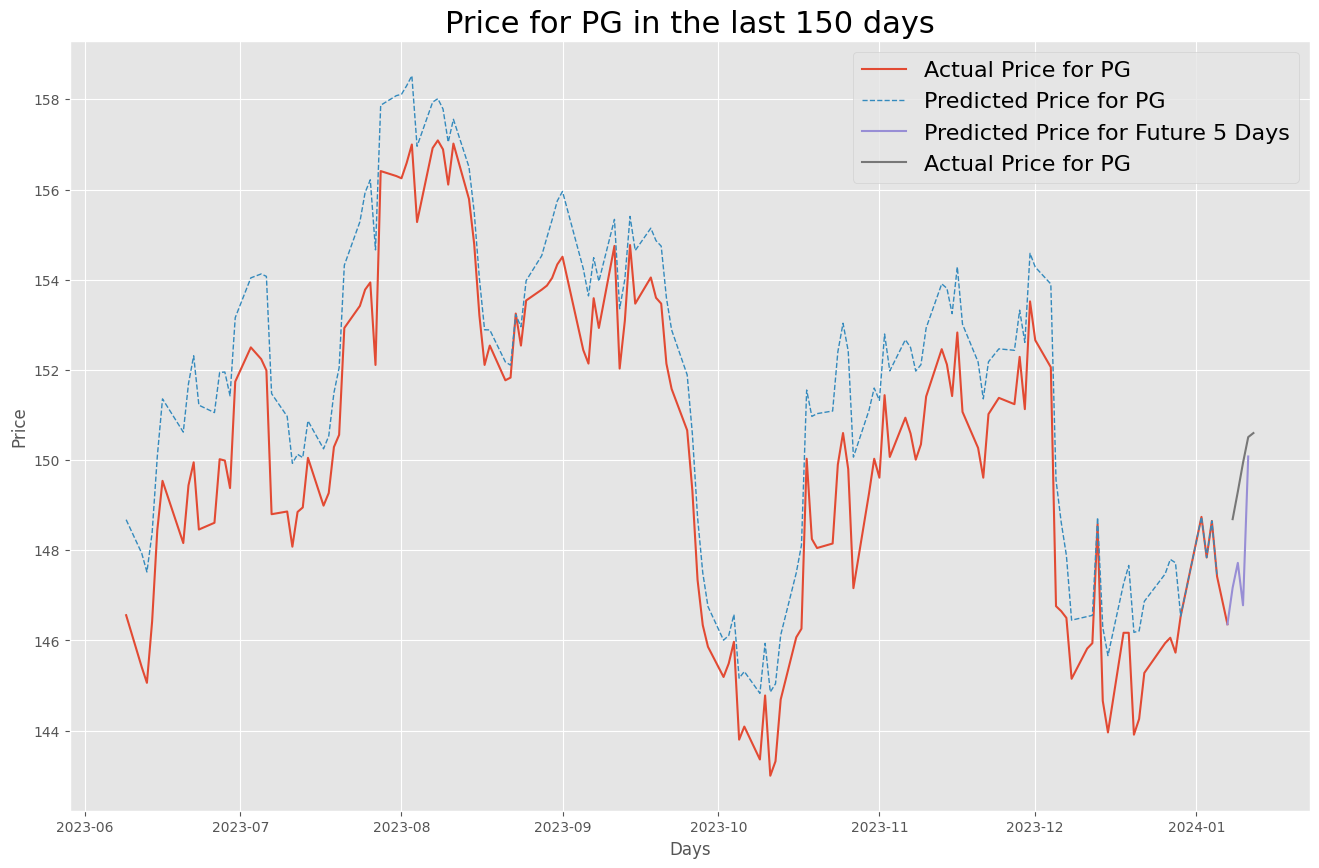

In [163]:
data_with_predictions = df_individual.copy()
data_with_predictions.dropna(inplace=True)
data_with_predictions = data_with_predictions.drop(['Adj Close', 'High', 'Low', 'Volume', 'Rsi', 'Macd', 'Atr'], axis=1)

red = len(STEPS)

# Generate model predictions
model_predictions = model.predict(input_sequences)
# print(len(model_predictions))
# print(len(data_with_predictions))
inverse_transformed_predictions = scaler.inverse_transform(model_predictions)

# Add edge predictions for a continuous sequence
inverse_transformed_predictions = np.concatenate([
    scaler.inverse_transform(target_values[:(N_days-1), np.newaxis]),
    inverse_transformed_predictions,
    scaler.inverse_transform(target_values[-len(STEPS):, np.newaxis])
])

# Add predictions to the DataFrame
data_with_predictions['Predicted_close'] = inverse_transformed_predictions

# Add predicted results for future dates
today = (dt.date.today() - dt.timedelta(days=8))
future_dates = [today + dt.timedelta(days=i) for i in range(red)]
future_predictions = all_predictions[:red]   # Assuming 'predictions' holds the 5 future values

# print(data_with_predictions)

for date, prediction in zip(future_dates, future_predictions):
    data_with_predictions.loc[date] = [prediction, 0, 0, 0, date.strftime('%Y-%m-%d'), 0]
    
# print(data_with_predictions)

# check the predictions against the actual price
check_cur_date = dt.date.today()
check_start_date = (dt.date.today() - dt.timedelta(days=8))

check_ind_stock_data = yf.download(STOCK, start = check_start_date, end = check_cur_date)

# Visualize results
plt.style.use('ggplot')
plt.figure(figsize=(16, 10))
plt.title(f'Price for {STOCK} in the last 150 days', fontsize=22)
plt.plot(data_with_predictions['Close'].tail(150).head(151 - red))
plt.plot(data_with_predictions['Predicted_close'].tail(150).head(150 - red), linewidth=1, linestyle='dashed')
plt.plot(data_with_predictions['Close'].tail(len(STEPS)))
plt.plot(check_ind_stock_data['Close'])
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend([f'Actual Price for {STOCK}', 
            f'Predicted Price for {STOCK}', 
            f'Predicted Price for Future {len(STEPS)} Days',
            f'Actual Price for {STOCK}'], fontsize=16)
plt.show()

In [164]:
# get the error in a percentage
miss = []
for acc_price, price in zip(check_ind_stock_data['Close'], all_predictions):
    print(acc_price, price)
    miss.append((abs(acc_price - price)*100)/price)
miss_avg = sum(miss)/len(miss)
print(f'The difference in % is {miss_avg}')

148.69000244140625 146.36
149.3000030517578 147.17
149.94000244140625 147.72
150.50999450683594 146.78
150.60000610351562 150.08
The difference in % is 1.4859639632446664


In [85]:
check_ind_stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-08,495.119995,522.750000,494.790009,522.530029,522.530029,64251000
2024-01-09,524.010010,543.250000,516.900024,531.400024,531.400024,77310000
2024-01-10,536.159973,546.000000,534.890015,543.500000,543.500000,53379600
2024-01-11,549.989990,553.460022,535.599976,548.219971,548.219971,59675900
2024-01-12,546.200012,549.700012,543.299988,547.099976,547.099976,35247900
